### IN THIS ASSIGNMENT I USED THE VGG ARCHITECTURE ALSO REFERRED SOME RESEARCH ARTICLES BY A Neural Algorithm of Artistic Style
Leon A. Gatys,1,2,3∗ Alexander S. Ecker,1,2,4,5 Matthias Bethge1,2,4

Research on Neural Style Transfer Algorithm Chengsi Yao1*, Yuanhao Li1, Yali Qi1 -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms, models

In [14]:
# Load the VGG16 model
vgg = models.vgg16(pretrained=True).features

# Freeze all VGG parameters since we're only interested in the features
for param in vgg.parameters():
    param.requires_grad_(False)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Cuda Available: ', torch.cuda.is_available())
vgg.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 187MB/s]  


Cuda Available:  True


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [15]:
def load_image(path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image is <= 400 pixels in the x-y dims. '''
    image = Image.open(path).convert('RGB')
    
    # Large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # Discard the alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [16]:
# Load content and style images
content = load_image('/kaggle/input/new-photo/NEWPHOTO.jpg').to(device)
style = load_image('/kaggle/input/best-artworks-of-all-time/images/images/Jackson_Pollock/Jackson_Pollock_9.jpg').to(device)

def imconvert(tensor):
    ''' Display a tensor as an image. '''
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


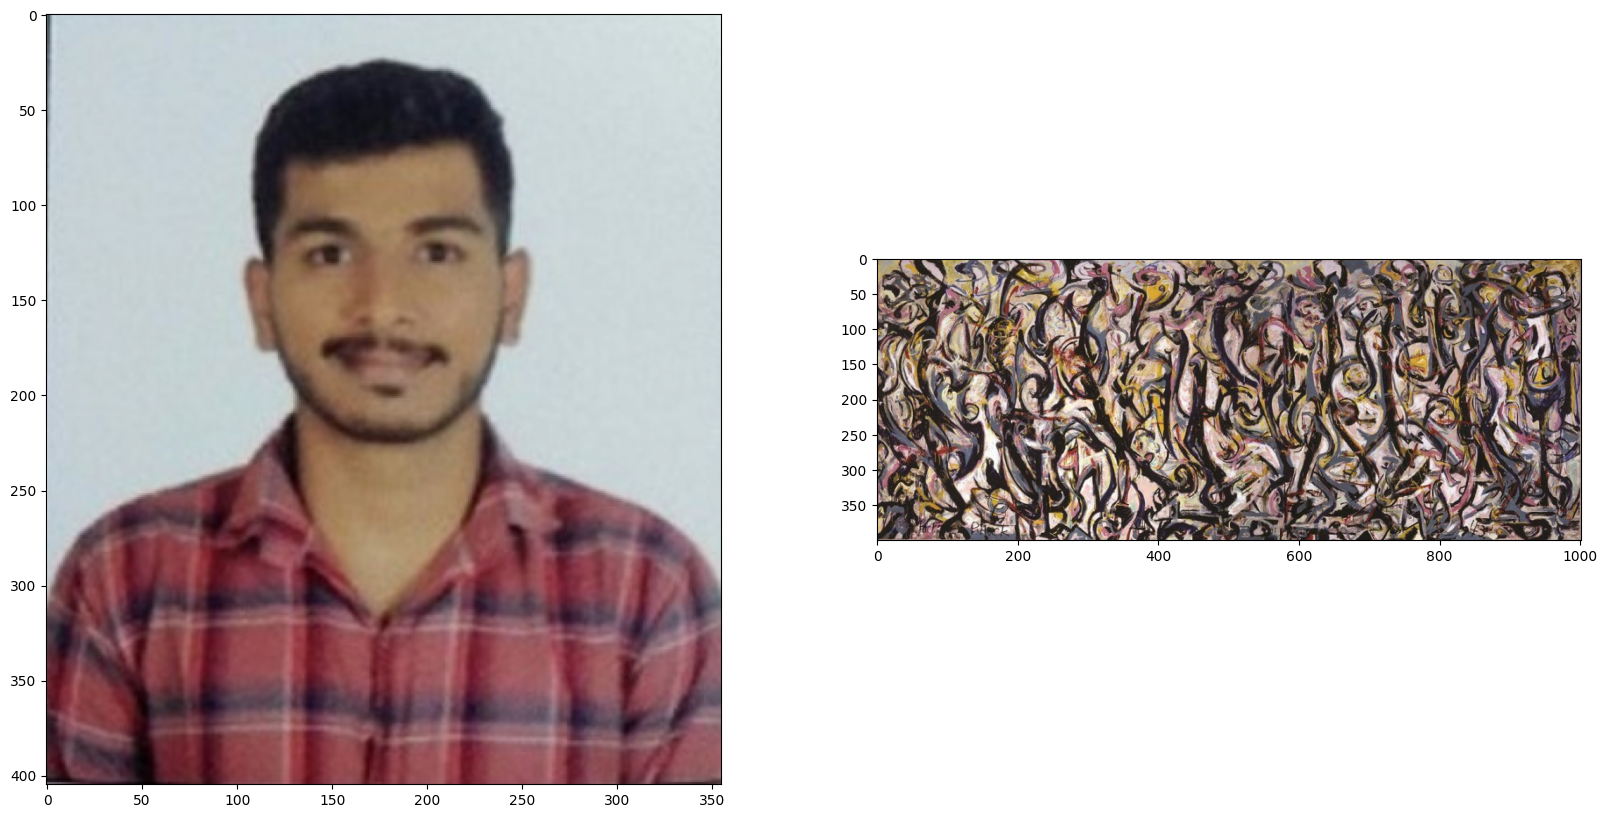

In [17]:
# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# Content and style side by side
ax1.imshow(imconvert(content))
ax2.imshow(imconvert(style))
plt.show()

In [18]:
def get_features(image, model, layers=None):
    ''' Run an image forward through a model and get the features for a set of layers. '''
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '17': 'conv4_1', '24': 'conv5_1', '19': 'conv4_2'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [19]:
def gram_matrix(tensor):
    ''' Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    '''
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram


In [20]:
# Get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a third "target" image and prep it for change
# It is a good idea to start off with the target as a copy of our content image
# Then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [21]:
# Weights for each style layer 
# Weights higher in the network should contribute more towards the total loss
style_weights = {'conv1_1': 1., 
                 'conv2_1': 0.8,
                 'conv3_1': 0.5, 
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta


In [22]:
# for displaying the target image, intermittently
show_every = 400

# Iteration hyperparameters
optimizer = torch.optim.Adam([target], lr=0.003)
steps = 2000  # Decide how many iterations to update your image (5000)

Total loss:  1208194944.0


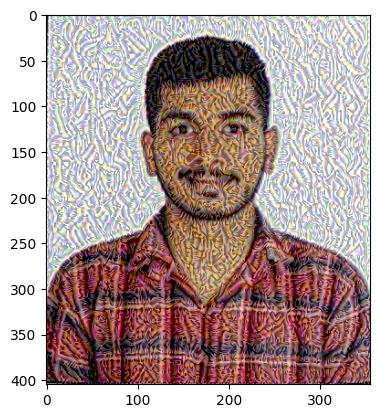

Total loss:  432837152.0


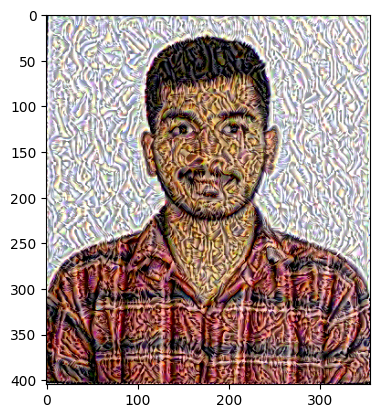

Total loss:  260071648.0


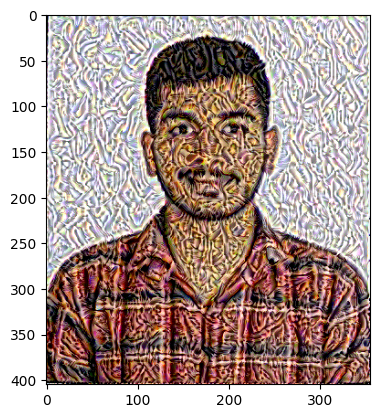

Total loss:  187248944.0


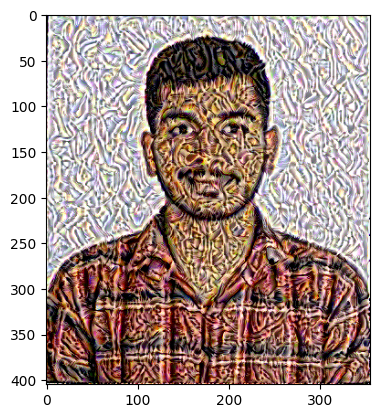

Total loss:  145989648.0


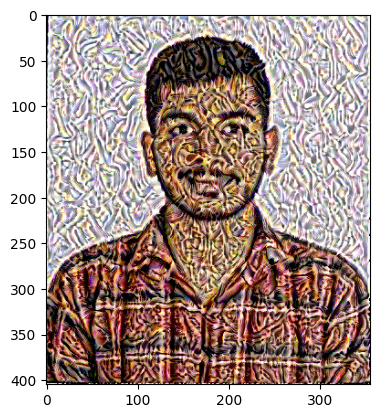

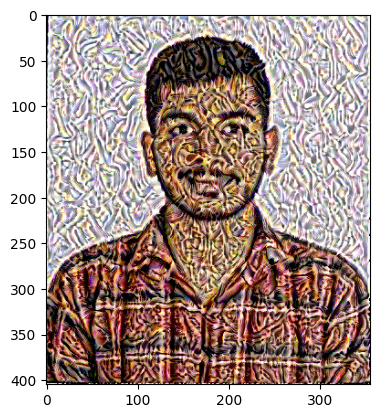

In [23]:
for ii in range(1, steps+1):
    
    # Get the features from your target image    
    target_features = get_features(target, vgg)
    
    # Calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # Initialize the style loss to 0
    style_loss = 0
    # Then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # Get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # Get the "style" style representation
        style_gram = style_grams[layer]
        # The style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # Add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # Calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # Update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(imconvert(target))
        plt.show()

# Display final image
plt.imshow(imconvert(target))
plt.savefig('final_target_image.png')

In [26]:
# I SHOWED THE OUTPUT IMAGES IN THE LOOPS TO SHOW THE REDUCING LOSS IN THE OUTPUT IMAGE 

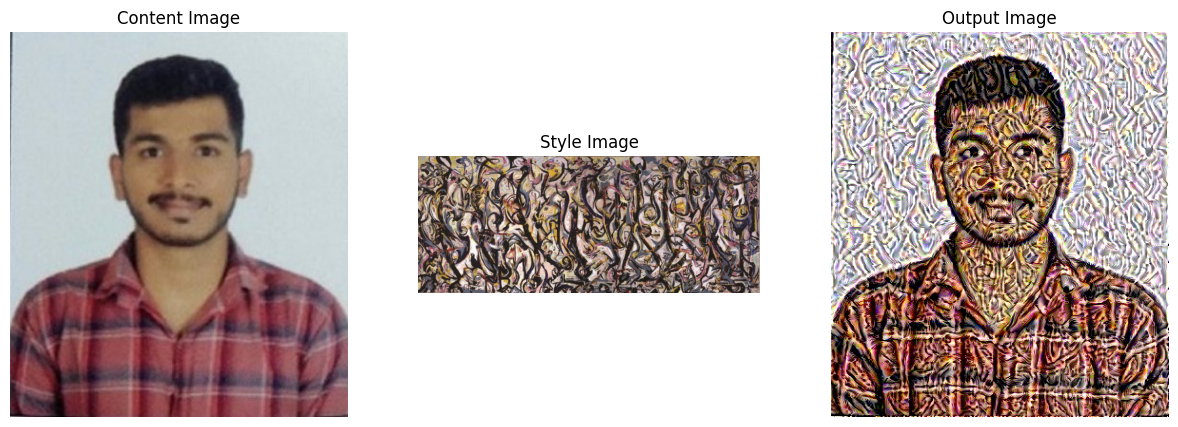

In [25]:
# Rest of the neural style transfer code...

# Final step after the loop
# Display the content, style, and target images side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Content image
ax1.imshow(imconvert(content))
ax1.set_title('Content Image')
ax1.axis('off')

# Style image
ax2.imshow(imconvert(style))
ax2.set_title('Style Image')
ax2.axis('off')

# Output (target) image
ax3.imshow(imconvert(target))
ax3.set_title('Output Image')
ax3.axis('off')

plt.show()
